In [2]:
print("hello")

hello


In [3]:
# Cell 2: Imports and Model Loading
import os
import csv
import cv2
import time

import numpy as np
import tensorflow as tf
import pandas as pd

# Import required classes and functions from your custom files
from data import BodyPart, Person, person_from_keypoints_with_scores
from movenet import Movenet

# Ensure the file exists in the directory
if 'movenet_thunder.tflite' in os.listdir():
    print(f"Found 'movenet_thunder.tflite', size: {os.path.getsize('movenet_thunder.tflite')} bytes")
else:
    raise FileNotFoundError("The 'movenet_thunder.tflite' file is missing. Please upload it to the working directory.")

# Initialize the MoveNet model
movenet = Movenet('movenet_thunder.tflite')
print("MoveNet model loaded successfully.")


ModuleNotFoundError: No module named 'cv2'

In [4]:
# Cell 3: Define detection function
def detect(input_tensor, inference_count=3):
    """Runs detection on an input image."""
    person = movenet.detect(input_tensor.numpy(), reset_crop_region=True)

    # Only run inference once for static images
    for _ in range(inference_count - 1):
        person = movenet.detect(input_tensor.numpy(), reset_crop_region=False)

    return person

In [3]:
import os
import csv
import numpy as np
import tensorflow as tf
import pandas as pd

class Preprocessor(object):
    def __init__(self, images_in_folder, csvs_out_path):
        self._images_in_folder = images_in_folder
        self._csvs_out_path = csvs_out_path
        self._csvs_out_folder_per_class = 'csv_per_pose'
        self._messages = []

        os.makedirs(self._csvs_out_folder_per_class, exist_ok=True)

        self._pose_class_names = sorted([
            n for n in os.listdir(self._images_in_folder)
            if os.path.isdir(os.path.join(self._images_in_folder, n))
        ])

    def process(self, detection_threshold=0.1):
        for pose_class_name in self._pose_class_names:
            print(f"Preprocessing {pose_class_name}...")
            
            images_in_folder = os.path.join(self._images_in_folder, pose_class_name)
            csv_out_path = os.path.join(self._csvs_out_folder_per_class, f"{pose_class_name}.csv")

            with open(csv_out_path, 'w', newline='') as csv_out_file:
                csv_out_writer = csv.writer(csv_out_file, delimiter=',', quoting=csv.QUOTE_MINIMAL)

                image_names = sorted([
                    n for n in os.listdir(images_in_folder)
                    if not n.startswith('.')
                ])

                valid_image_count = 0

                for index, image_name in enumerate(image_names):
                    print(f"Processing {index + 1}/{len(image_names)}: {image_name}")
                    image_path = os.path.join(images_in_folder, image_name)

                    try:
                        image = tf.io.read_file(image_path)
                        image = tf.io.decode_jpeg(image)
                    except Exception as e:
                        self._messages.append(f"Skipped {image_path}: Invalid image: {str(e)}")
                        continue

                    if image.shape[-1] != 3:
                        self._messages.append(f"Skipped {image_path}: Image is not in RGB")
                        continue

                    person = detect(image)

                    min_landmark_score = min([keypoint.score for keypoint in person.keypoints])
                    if min_landmark_score < detection_threshold:
                        self._messages.append(f"Skipped {image_path}: Keypoint score below threshold")
                        continue

                    valid_image_count += 1

                    pose_landmarks = np.array([
                        [keypoint.coordinate.x, keypoint.coordinate.y, keypoint.score]
                        for keypoint in person.keypoints
                    ], dtype=np.float32)

                    coord = pose_landmarks.flatten().astype(str).tolist()
                    csv_out_writer.writerow([image_name] + coord)

        all_landmarks_df = self._all_landmarks_as_dataframe()
        all_landmarks_df.to_csv(self._csvs_out_path, index=False)
        print(f"Combined CSV file saved at: {self._csvs_out_path}")

        if self._messages:
            print("Messages/Warnings during preprocessing:")
            for message in self._messages:
                print(message)

    def class_names(self):
        return self._pose_class_names

    def _all_landmarks_as_dataframe(self):
        total_df = None
        for class_index, class_name in enumerate(self._pose_class_names):
            csv_out_path = os.path.join(self._csvs_out_folder_per_class, f"{class_name}.csv")
            per_class_df = pd.read_csv(csv_out_path, header=None)

            per_class_df['class_no'] = [class_index] * len(per_class_df)
            per_class_df['class_name'] = [class_name] * len(per_class_df)
            per_class_df[per_class_df.columns[0]] = (
                    class_name + '/' + per_class_df[per_class_df.columns[0]])

            if total_df is None:
                total_df = per_class_df
            else:
                total_df = pd.concat([total_df, per_class_df], axis=0)

        list_name = [[bodypart.name + '_x', bodypart.name + '_y', bodypart.name + '_score'] for bodypart in BodyPart]
        header_name = ['filename']
        for columns_name in list_name:
            header_name += columns_name
        header_map = {total_df.columns[i]: header_name[i]
                      for i in range(len(header_name))}

        total_df.rename(header_map, axis=1, inplace=True)
        return total_df

In [7]:
# Cell 5: Instantiate and run the preprocessor (for training data)
import os

images_in_folder = 'Final_datasets/Train'  # Adjust path to training data
csvs_out_path = 'train_data_final.csv'

train_preprocessor = Preprocessor(images_in_folder, csvs_out_path)

# Manual progress tracking
image_files = os.listdir(images_in_folder)
total_images = len(image_files)

for index, image_name in enumerate(image_files):
    print(f"Processing {index + 1}/{total_images}: {image_name}")
    train_preprocessor.process()  # Ensure this method handles each image internally


Processing 1/5: chair
Preprocessing chair...
Processing 1/400: girl1_chair070.jpg
Processing 2/400: girl1_chair070_flipped.jpg
Processing 3/400: girl1_chair075.jpg
Processing 4/400: girl1_chair075_flipped.jpg
Processing 5/400: girl1_chair076.jpg
Processing 6/400: girl1_chair076_flipped.jpg
Processing 7/400: girl1_chair080.jpg
Processing 8/400: girl1_chair080_flipped.jpg
Processing 9/400: girl1_chair081.jpg
Processing 10/400: girl1_chair081_flipped.jpg
Processing 11/400: girl1_chair085.jpg
Processing 12/400: girl1_chair085_flipped.jpg
Processing 13/400: girl1_chair090.jpg
Processing 14/400: girl1_chair090_flipped.jpg
Processing 15/400: girl1_chair091.jpg
Processing 16/400: girl1_chair091_flipped.jpg
Processing 17/400: girl1_chair094.jpg
Processing 18/400: girl1_chair094_flipped.jpg
Processing 19/400: girl1_chair104.jpg
Processing 20/400: girl1_chair104_flipped.jpg
Processing 21/400: girl1_chair106.jpg
Processing 22/400: girl1_chair106_flipped.jpg
Processing 23/400: girl1_chair107.jpg
Pr

In [8]:
# Cell 6: Instantiate and run the preprocessor (for test data)
import os

images_in_folder = 'Final_datasets/Test'  # Adjust path to test data
csvs_out_path = 'test_data_final.csv'

test_preprocessor = Preprocessor(images_in_folder, csvs_out_path)

# Manual progress tracking
image_files = os.listdir(images_in_folder)
total_images = len(image_files)

for index, image_name in enumerate(image_files):
    print(f"Processing {index + 1}/{total_images}: {image_name}")
    test_preprocessor.process()  # Ensure this method handles each image internally


Processing 1/5: chair
Preprocessing chair...
Processing 1/168: guy3_chair070.jpg
Processing 2/168: guy3_chair070_flipped.jpg
Processing 3/168: guy3_chair071.jpg
Processing 4/168: guy3_chair071_flipped.jpg
Processing 5/168: guy3_chair072.jpg
Processing 6/168: guy3_chair072_flipped.jpg
Processing 7/168: guy3_chair073.jpg
Processing 8/168: guy3_chair073_flipped.jpg
Processing 9/168: guy3_chair074.jpg
Processing 10/168: guy3_chair074_flipped.jpg
Processing 11/168: guy3_chair075.jpg
Processing 12/168: guy3_chair075_flipped.jpg
Processing 13/168: guy3_chair076.jpg
Processing 14/168: guy3_chair076_flipped.jpg
Processing 15/168: guy3_chair077.jpg
Processing 16/168: guy3_chair077_flipped.jpg
Processing 17/168: guy3_chair078.jpg
Processing 18/168: guy3_chair078_flipped.jpg
Processing 19/168: guy3_chair079.jpg
Processing 20/168: guy3_chair079_flipped.jpg
Processing 21/168: guy3_chair080.jpg
Processing 22/168: guy3_chair080_flipped.jpg
Processing 23/168: guy3_chair081.jpg
Processing 24/168: guy3_c

In [4]:

import pandas as pd

# Load the training CSV generated by your preprocessor.
df_train = pd.read_csv('train_data_final.csv')

# Extract unique class names from the "class_name" column.
class_names = df_train['class_name'].unique()

print("Unique class names:", class_names)


Unique class names: ['chair' 'cobra' 'downdog' 'plank' 'shoudler_stand']


In [5]:
tf.keras.backend.clear_session()  # Clears previous sessions to free up resources.

# Update input shape to (51,) since your data has 51 features.
inputs = tf.keras.Input(shape=(51,))

layer = tf.keras.layers.Dense(128, activation=tf.nn.relu6)(inputs)
layer = tf.keras.layers.Dropout(0.5)(layer)
layer = tf.keras.layers.Dense(64, activation=tf.nn.relu6)(layer)
layer = tf.keras.layers.Dropout(0.2)(layer)
outputs = tf.keras.layers.Dense(len(class_names), activation="softmax")(layer)

model = tf.keras.Model(inputs, outputs)
model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 51)]              0         
                                                                 
 dense (Dense)               (None, 128)               6656      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 5)                 325       
                                                                 
Total params: 15237 (59.52 KB)
Trainable params: 15237 (59.5

In [6]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  # Use categorical crossentropy for one-hot encoded labels.
    metrics=['accuracy']              # Track accuracy during training and evaluation.
)


In [7]:

from tensorflow import keras

checkpoint_path = "weights.best.keras"
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                                               monitor='val_accuracy',  # Monitor validation accuracy.
                                               verbose=1,
                                               save_best_only=True,
                                               mode='max')

earlystopping = keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                patience=20)


In [8]:

from sklearn.model_selection import train_test_split


# Load the data from CSV.
df_train = pd.read_csv('train_data_final.csv')

# Define the features and labels.
X = df_train.drop(['filename', 'class_no', 'class_name'], axis=1)
y = df_train['class_no']
y = tf.keras.utils.to_categorical(y)

# Optionally preprocess the data.
# X = preprocess_data(X)  # Uncomment if using a preprocessing function.

# Split the data.
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)

# Now that X_train, y_train, X_val, and y_val are defined, train the model.
num_epochs = 200  # Total epochs to train.

history = model.fit(X_train, y_train,
                    epochs=num_epochs,
                    batch_size=16,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint, earlystopping])


Epoch 1/200


36/56 [==================>...........] - ETA: 0s - loss: 3.4339 - accuracy: 0.2604 
Epoch 1: val_accuracy improved from -inf to 0.52866, saving model to weights.best.keras
56/56 [==============================] - 1s 6ms/step - loss: 3.0819 - accuracy: 0.3036 - val_loss: 1.2346 - val_accuracy: 0.5287
Epoch 2/200
36/56 [==================>...........] - ETA: 0s - loss: 2.2907 - accuracy: 0.3785
Epoch 2: val_accuracy improved from 0.52866 to 0.63057, saving model to weights.best.keras
56/56 [==============================] - 0s 2ms/step - loss: 2.2087 - accuracy: 0.3815 - val_loss: 1.0304 - val_accuracy: 0.6306
Epoch 3/200
35/56 [=================>............] - ETA: 0s - loss: 1.7304 - accuracy: 0.4446
Epoch 3: val_accuracy improved from 0.63057 to 0.66242, saving model to weights.best.keras
56/56 [==============================] - 0s 3ms/step - loss: 1.7355 - accuracy: 0.4549 - val_loss: 0.9101 - val_accuracy: 0.6624
Epoch 4/200
43/56 [======================>.......] - ET

In [9]:
\

# Load test data from CSV (adjust file name/path as needed)
df_test = pd.read_csv('test_data_final.csv')

# Define features and labels from the test data
X_test = df_test.drop(['filename', 'class_no', 'class_name'], axis=1)
y_test = df_test['class_no']
y_test = tf.keras.utils.to_categorical(y_test)

# If you have a preprocessing function, apply it:
# processed_X_test = preprocess_data(X_test)
# Otherwise, if no additional processing is needed, use X_test directly:
processed_X_test = X_test  # Remove or adjust this line if preprocessing is required

# Now evaluate the model on the test data
loss, accuracy = model.evaluate(processed_X_test, y_test)
print('Test accuracy: {:2.2f}%'.format(accuracy * 100))


18/18 [==============================] - 0s 2ms/step - loss: 0.2704 - accuracy: 0.9609
Test accuracy: 96.09%


In [10]:


model.save('my_model.h5')
print('Model saved in HDF5 format as "my_model.h5"')



Model saved in HDF5 format as "my_model.h5"


C:\Users\Hello Tejas\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


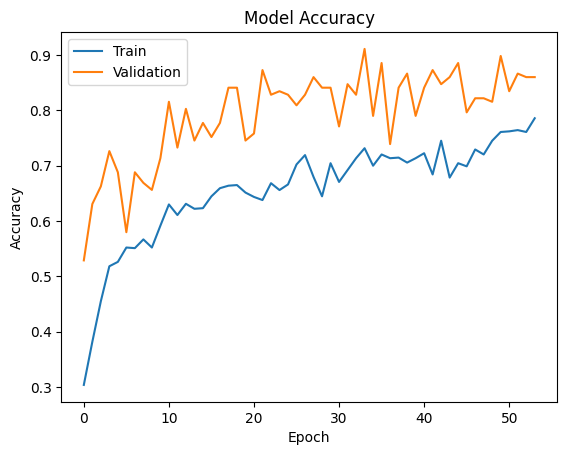

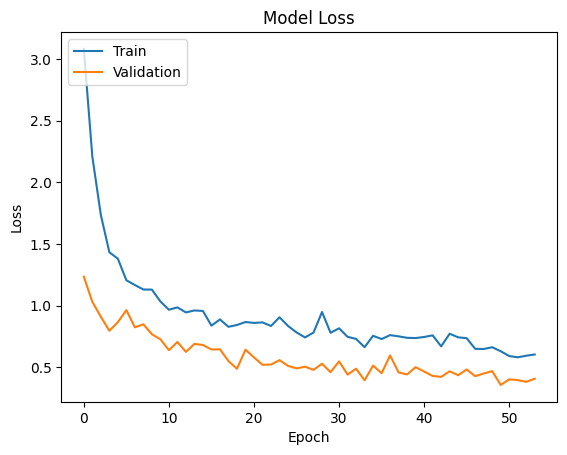

In [11]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()




In [5]:
import tensorflowjs as tfjs

# # Change the directory name to something unique.
# tfjs_model_dir = 'my_custom_tfjs_model'
# tfjs.converters.save_keras_model(model, tfjs_model_dir)
# print('TFJS model saved at', tfjs_model_dir)

print(tfjs.__version__)


NotFoundError: C:\Users\Hello Tejas\AppData\Roaming\Python\Python39\site-packages\tensorflow_decision_forests\tensorflow\ops\inference\inference.so not found

In [6]:
import tensorflowjs as tfjs
from tensorflow import keras

# Load the Keras model
model = keras.models.load_model("my_model.h5")

# Convert and save the model in TensorFlow.js format
tfjs.converters.save_keras_model(model, "tfjs_model")


NotFoundError: C:\Users\Hello Tejas\AppData\Roaming\Python\Python39\site-packages\tensorflow_decision_forests\tensorflow\ops\inference\inference.so not found